# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-23 08:24:54.387866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

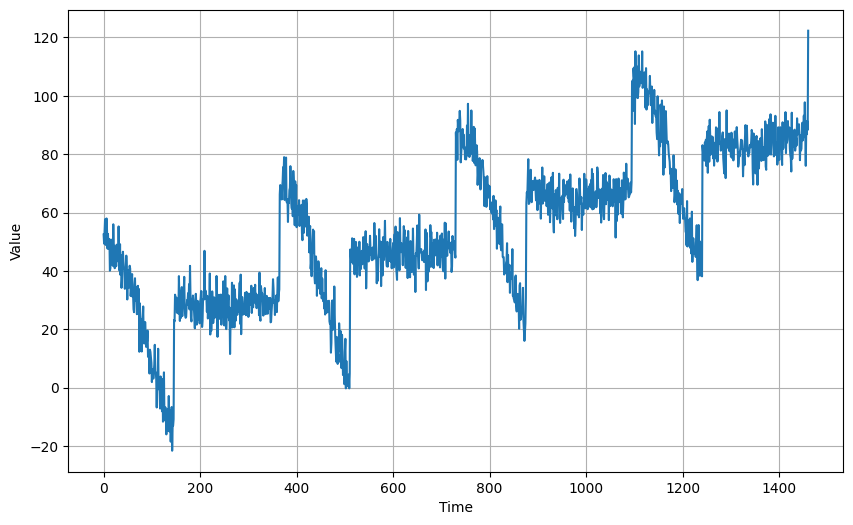

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-23 08:24:59.640974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
33/33 [==============================] - 3s 22ms/step - loss: 89.5907 - mae: 90.0903 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 81.1136 - mae: 81.6130 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 71.4901 - mae: 71.9901 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 58.5508 - mae: 59.0508 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 43.0999 - mae: 43.5999 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 29.8443 - mae: 30.3440 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 16.5897 - mae: 17.0804 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 11.3217 - mae: 11.8106 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 9ms/step - loss: 9.2271 - mae: 9.7151

(1e-08, 0.0001, 0.0, 30.0)

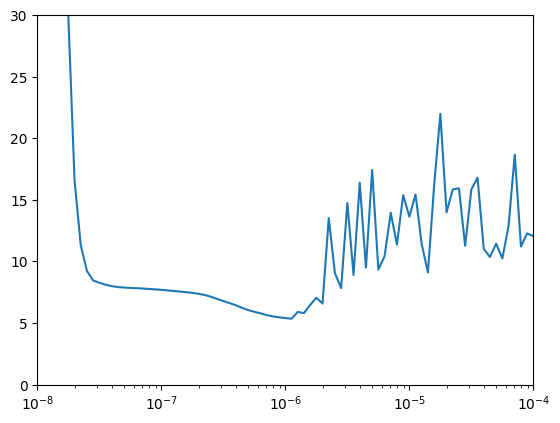

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 36ms/step - loss: 2472.9414 - mae: 2473.4409 - val_loss: 10582.6436 - val_mae: 10583.1436
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 5257.9932 - mae: 5258.4922 - val_loss: 2092.8752 - val_mae: 2093.3755
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 2863.3831 - mae: 2863.8835 - val_loss: 2301.3462 - val_mae: 2301.8459
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 2998.8757 - mae: 2999.3760 - val_loss: 1896.7264 - val_mae: 1897.2267
Epoch 5/500
33/33 [==============================] - 1s 15ms/step - loss: 3171.3884 - mae: 3171.8889 - val_loss: 4108.2900 - val_mae: 4108.7900
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 3137.9492 - mae: 3138.4495 - val_loss: 1590.4341 - val_mae: 1590.9338
Epoch 7/500
33/33 [==============================] - 0s 12ms/step - loss: 3082.5571 - mae: 3083.0569 - val_loss: 4115.9321 - val_mae: 

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 737ms/step


## Mechanized Forecasting with LSTM

In [11]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism


In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

gaussian_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
33/33 [==============================] - 3s 9ms/step - loss: 81.1501 - mae: 81.6488 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 76.2238 - mae: 76.7248 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 11ms/step - loss: 70.3347 - mae: 70.8356 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 11ms/step - loss: 63.7231 - mae: 64.2244 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 56.3158 - mae: 56.8138 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 48.0191 - mae: 48.5201 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 38.7874 - mae: 39.2862 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 11ms/step - loss: 29.2426 - mae: 29.7407 - lr: 2.2387e-08
Epoch 9/100
33/33 [===========================

(1e-08, 0.0001, 0.0, 30.0)

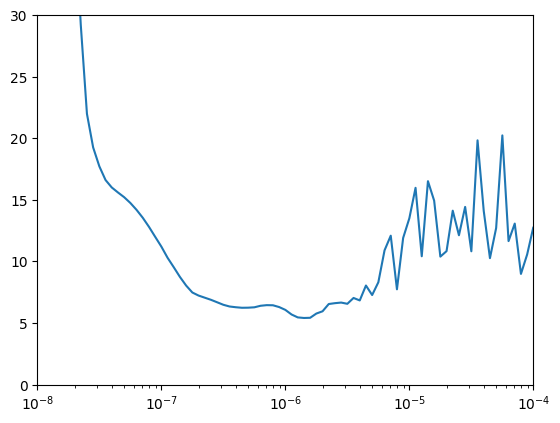

In [13]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

gaussian_model = MechanizedSequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)



optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint.h5", save_best_only=True)
gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, gaussian_model_checkpoint, reset_states])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
     32/Unknown - 3s 9ms/step - loss: 2001.1317 - mae: 2001.6335In Gaussian Mechanism


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


33/33 [==============================] - 10s 244ms/step - loss: 2034.0729 - mae: 2034.5747 - val_loss: 1168.2468 - val_mae: 1168.7452
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 2757.3452 - mae: 2757.8442 - val_loss: 5399.9829 - val_mae: 5400.4829
Epoch 3/500
32/33 [============================>.] - ETA: 0s - loss: 2513.8660 - mae: 2514.3674

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


33/33 [==============================] - 7s 222ms/step - loss: 2470.8989 - mae: 2471.4009 - val_loss: 287.1375 - val_mae: 287.6370
Epoch 4/500
33/33 [==============================] - 0s 12ms/step - loss: 3757.8179 - mae: 3758.3159 - val_loss: 6078.1504 - val_mae: 6078.6475
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 5551.7402 - mae: 5552.2407 - val_loss: 6251.8604 - val_mae: 6252.3599
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 4482.9312 - mae: 4483.4316 - val_loss: 1786.6301 - val_mae: 1787.1298
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 1949.2952 - mae: 1949.7981 - val_loss: 1819.2437 - val_mae: 1819.7458
Epoch 8/500
33/33 [==============================] - 0s 11ms/step - loss: 3335.7896 - mae: 3336.2883 - val_loss: 3817.1072 - val_mae: 3817.6072
Epoch 9/500
33/33 [==============================] - 0s 12ms/step - loss: 3889.4465 - mae: 3889.9443 - val_loss: 940.6046 - val_mae: 941.1070
Epoch 1

In [20]:
gaussian_model = keras.models.load_model("gaussian_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [21]:
gaussian_rnn_forecast = gaussian_model.predict(series[np.newaxis, :, np.newaxis])
gaussian_rnn_forecast = gaussian_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 697ms/step


## Plot the comparison results

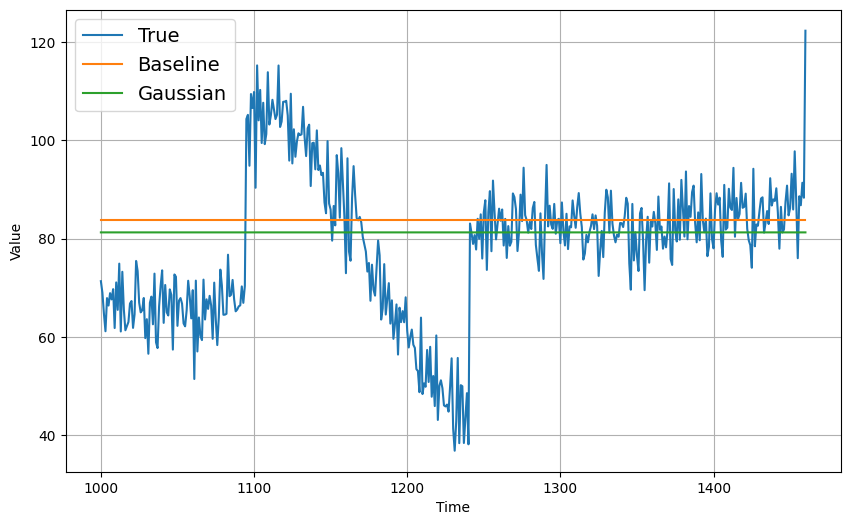

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [24]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.885803

In [25]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

11.526443